Using backend: pytorch



20
Compiling model...
'compile' took 0.000950 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [9.64e+03, 1.90e+01]    [1.09e+04, 1.90e+01]    [1.29e+00]    
1000      [1.98e+03, 2.06e+01]    [2.32e+03, 2.06e+01]    [1.39e+00]    
2000      [3.82e+02, 3.72e+01]    [1.77e+03, 3.72e+01]    [1.71e+00]    
3000      [5.94e+01, 3.03e+01]    [2.83e+03, 3.03e+01]    [1.72e+00]    
4000      [2.88e+01, 1.94e+01]    [3.72e+03, 1.94e+01]    [1.65e+00]    
5000      [1.14e+01, 1.39e+01]    [4.41e+03, 1.39e+01]    [1.60e+00]    
6000      [1.44e+01, 9.48e+00]    [4.71e+03, 9.48e+00]    [1.53e+00]    
7000      [3.90e+00, 5.98e+00]    [5.10e+03, 5.98e+00]    [1.46e+00]    
8000      [2.78e+00, 3.57e+00]    [5.23e+03, 3.57e+00]    [1.41e+00]    
9000      [1.64e+00, 2.17e+00]    [5.22e+03, 2.17e+00]    [1.36e+00]    
10000     [2.23e+00, 1.35e+00]    [5.12e+03, 1.35e+00]    [1.33e+00]    
11000     [4.10e+00, 8.62e-01]    [4.88e+03, 8.62e-01]  

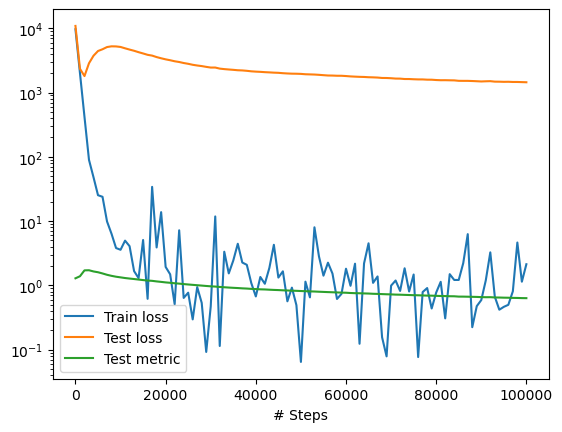

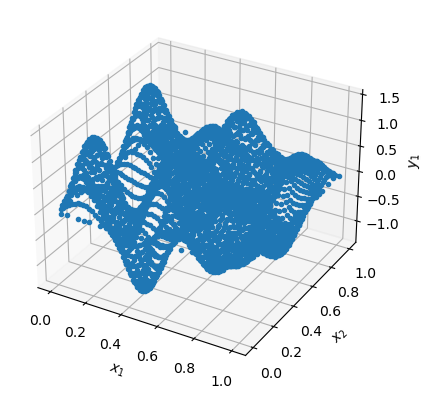

In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import os
os.environ['DDE_BACKEND']="pytorch"

import deepxde as dde
import numpy as np

# General parameters
n = 2
precision_train = 10
precision_test = 30
hard_constraint = False
weights = 100  # if hard_constraint == False
iterations = 100000
parameters = [1e-3, 3, 150, "tanh"]

# Define sine function
if dde.backend.backend_name == "pytorch":
    sin = dde.backend.pytorch.sin
else:
    from deepxde.backend import tf

    sin = tf.sin

learning_rate, num_dense_layers, num_dense_nodes, activation = parameters


def pde(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)

    f = k0 ** 2 * sin(k0 * x[:, 0:1]) * sin(k0 * x[:, 1:2])
    return -dy_xx - dy_yy - k0 ** 2 * y - f


def func(x):
    return np.sin(k0 * x[:, 0:1]) * np.sin(k0 * x[:, 1:2])


def transform(x, y):
    res = x[:, 0:1] * (1 - x[:, 0:1]) * x[:, 1:2] * (1 - x[:, 1:2])
    return res * y


def boundary(_, on_boundary):
    return on_boundary

geom = dde.geometry.Rectangle([0, 0], [1, 1])
k0 = 2 * np.pi * n
wave_len = 1 / n

hx_train = wave_len / precision_train
nx_train = int(1 / hx_train)

hx_test = wave_len / precision_test
nx_test = int(1 / hx_test)

if hard_constraint == True:
    bc = []
else:
    bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary)

print(nx_train)
data = dde.data.PDE(
    geom,
    pde,
    bc,
    num_domain=nx_train ** 2,
    num_boundary=4 * nx_train,
    solution=func,
    num_test=nx_test ** 2,
)

net = dde.nn.FNN(
    [2] + [num_dense_nodes] * num_dense_layers + [1], activation, "He uniform"
)

if hard_constraint == True:
    net.apply_output_transform(transform)

model = dde.Model(data, net)

if hard_constraint == True:
    model.compile("adam", lr=learning_rate, metrics=["l2 relative error"])
else:
    loss_weights = [1, weights]
    model.compile(
        "adam",
        lr=learning_rate,
        metrics=["l2 relative error"],
        loss_weights=loss_weights,
    )


losshistory, train_state = model.train(iterations=iterations)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

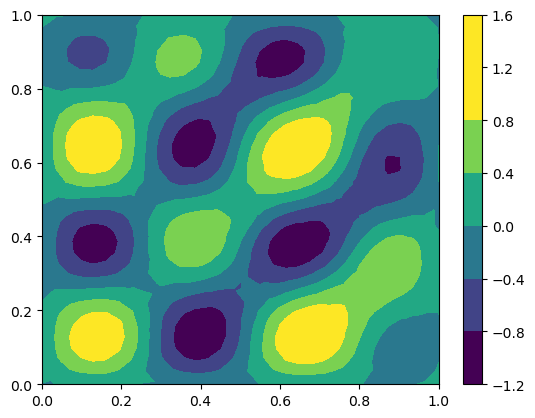

0.22094797

In [2]:
import matplotlib
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

import matplotlib.pyplot as plt
x = geom.uniform_points(1000, True)
y = model.predict(x)
plt.figure()
cm1 = plt.tricontourf(x[:,0].ravel(),x[:,[1]].ravel(),y.ravel(),norm = norm)
plt.colorbar(cm1)
plt.show()


def anal_solve(pde_input):
    k0 = 2 * np.pi * 2
    plot_x = pde_input[:,0]
    plot_y = pde_input[:,1]
    return np.sin(k0*plot_x)*np.sin(k0*plot_y)

np.array(np.abs(y.ravel()- anal_solve(x))).mean()